# ECS 171 Group Project - Group 10 - ???

## Clean/Wrangle Data

"Process the data the same way the paper author did"

In [2]:
import pandas as pd

#Contains 81 features extracted from 21263 superconductors along with the critical temperature in the 82nd column
train = pd.read_csv('./../superconduct/train.csv')

#Contains the chemical formula broken up for all the 21263 superconductors from the train.csv file.
#The last two columns have the critical temperature and chemical formula.
formula = pd.read_csv('./../superconduct/unique_m.csv')

print("Training Data")
print(train.shape)
print(train.head())

print("\nChemical formulas")
print(formula.shape)
print(formula.head())

Training Data
(21263, 82)
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755    

## Replicate original XGBoost model

## Optimize XGBoost model with tuned hyperparameters

## Train and test a Random Forest model

In [3]:
# sources: https://www.youtube.com/watch?v=0GrciaGYzV0

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
import pandas as pd

X = train.drop("critical_temp", axis = 1)
y = train['critical_temp']

X.describe()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,4.115224,87.557631,72.988310,71.290627,58.539916,1.165608,1.063884,115.601251,33.225218,44.391893,...,3.198228,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987
std,1.439295,29.676497,33.490406,31.030272,36.651067,0.364930,0.401423,54.626887,26.967752,20.035430,...,1.044611,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580
min,1.000000,6.941000,6.423452,5.320573,1.960849,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,72.458076,52.143839,58.041225,35.248990,0.966676,0.775363,78.512902,16.824174,32.890369,...,2.333333,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892
50%,4.000000,84.922750,60.696571,66.361592,39.918385,1.199541,1.146783,122.906070,26.636008,45.123500,...,2.833333,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000
75%,5.000000,100.404410,86.103540,78.116681,73.113234,1.444537,1.359418,154.119320,38.356908,59.322812,...,4.000000,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436
max,9.000000,208.980400,208.980400,208.980400,208.980400,1.983797,1.958203,207.972460,205.589910,101.019700,...,7.000000,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000


In [23]:
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.25,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.25,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809


In [ ]:
# data preprocessing such as: droppings some columns, normalizing, enchoding and so on....
#...
#...
#...

In [24]:
# building and fitting the model
model = RandomForestRegressor(n_estimators = 100, oob_score = True)
model.fit(X[numeric_variables],y)

RandomForestRegressor(oob_score=True)

In [28]:
# checking the efficiency of the model
model.oob_score_
y_oob = model.oob_prediction_

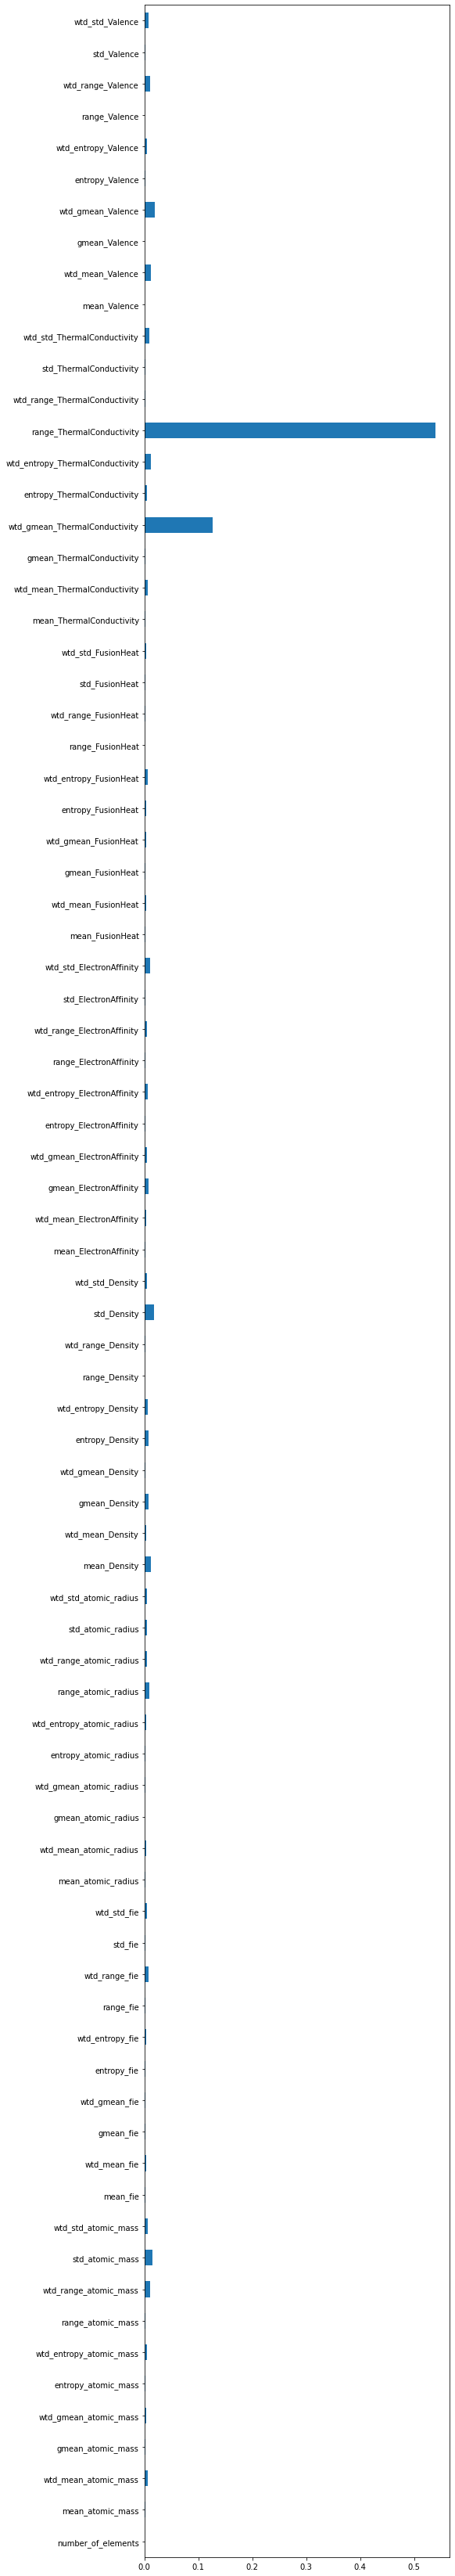

In [30]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values()
feature_importances.plot(kind="barh",figsize=(7,60));

## Optimize Random Forest model with tuned hyperparameters

In [ ]:
# optimizing for n_jobs
%%timeit
model = RandomForestRegressor(n_estimators = 1000, oob_score = True,n_jobs=1)
model.fit(X,y)

In [ ]:
%%timeit
model = RandomForestRegressor(n_estimators = 1000, oob_score = True,n_jobs=1)
model.fit(X,y)

In [ ]:
# optimizing for number of estimators
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]
for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score = True,n_jobs=1)
    model.fit(X,y)
    print(trees, "trees")
    oob_score = model.oob_score_
    results.append(oob_score)
    print ""
pd.Series(results, n_estimator_options).plot();

In [ ]:
# optimizing for max_features
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimatore=1000, oob_score = True,n_jobs=-1, max_features=max_features)
    model.fit(X,y)
    print(trees, "trees")
    oob_score = model.oob_score_
    results.append(oob_score)
    print ""
pd.Series(results, max_features_options).plot(kind = "barh", xlim=(.85,.88));

In [ ]:
# optimizing for min_sample_leaf
min_sample_leaf_options=[1,2,3,4,5,6,7,8,9,10]

for min_samples in min_sample_leaf_options:
    model = RandomForestRegressor(n_estimatore=1000, 
                                  oob_score = True,
                                  n_jobs=-1, 
                                  max_features="auto",
                                  min_samples_leaf=min_samples)
    model.fit(X,y)
    print(min_samples, "min_samples")
    oob_score = model.oob_score_
    results.append(oob_score)
    print ""
pd.Series(results, min_sample_leaf_options).plot();

In [ ]:
# the final model after optimization
model = RandomForestRegressor(n_estimatore=1000, 
                                  oob_score = True,
                                  n_jobs=-1, 
                                  max_features="auto",
                                  min_samples_leaf=3)
model.fit(X,y)
oob_score = model.oob_score_
print("oob_score: ",oob_score)

## Research Bayesian Neural Networks
## Train and test a Bayesian Neural Network

In [22]:
# Code  source for BNN https://towardsdatascience.com/making-your-neural-network-say-i-dont-know-bayesian-nns-using-pyro-and-pytorch-b1c24e6ab8cd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from blitz.modules.base_bayesian_module import BayesianModule

from blitz.modules.weight_sampler import TrainableRandomDistribution
from blitz.losses import kl_divergence_from_nn
from blitz.modules.base_bayesian_module import BayesianModule, BayesianRNN


In [23]:
X = train.drop("critical_temp", axis = 1)
y = train['critical_temp']
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .3,
                                                    random_state = 42)


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [24]:
X_train.shape

torch.Size([14884, 81])

In [25]:
#variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 100)
        self.blinear2 = BayesianLinear(100, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        return self.blinear2(x_)
    
    
#from https://github.com/piEsposito/blitz-bayesian-deep-learning/blob/3526b57058e0914105e17cf7e93682ef11a9cd28/blitz/utils/variational_estimator.py#L35    
    def nn_kl_divergence(self):
        """Returns the sum of the KL divergence of each of the BayesianModules of the model, which are from
            their posterior current distribution of weights relative to a scale-mixtured prior (and simpler) distribution of weights
            Parameters:
                N/a
            Returns torch.tensor with 0 dim.      
        
        """
        return kl_divergence_from_nn(self)
    
    def sample_elbo(self,
                    inputs,
                    labels,
                    criterion,
                    sample_nbr,
                    complexity_cost_weight=1):

        """ Samples the ELBO Loss for a batch of data, consisting of inputs and corresponding-by-index labels
                The ELBO Loss consists of the sum of the KL Divergence of the model 
                 (explained above, interpreted as a "complexity part" of the loss)
                 with the actual criterion - (loss function) of optimization of our model
                 (the performance part of the loss). 
                As we are using variational inference, it takes several (quantified by the parameter sample_nbr) Monte-Carlo
                 samples of the weights in order to gather a better approximation for the loss.
            Parameters:
                inputs: torch.tensor -> the input data to the model
                labels: torch.tensor -> label data for the performance-part of the loss calculation
                        The shape of the labels must match the label-parameter shape of the criterion (one hot encoded or as index, if needed)
                criterion: torch.nn.Module, custom criterion (loss) function, torch.nn.functional function -> criterion to gather
                            the performance cost for the model
                sample_nbr: int -> The number of times of the weight-sampling and predictions done in our Monte-Carlo approach to 
                            gather the loss to be .backwarded in the optimization of the model.        
        
        """

        loss = 0
        for _ in range(sample_nbr):
            outputs = self(inputs)
            loss += criterion(outputs, labels) 
            loss += self.nn_kl_divergence() * complexity_cost_weight
            
        return loss / sample_nbr

In [26]:
def evaluate_regression(regressor,
                        X_train,
                        y_train,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

In [27]:
regressor = BayesianRegressor(81, 1)
optimizer = optim.Adam(regressor.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=32, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=32, shuffle=True)

In [28]:

iteration = 0
for epoch in range(100):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints,
                           labels=labels,
                           criterion=criterion,
                           sample_nbr=3)

        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                                        X_test,
                                                                        y_test,
                                                                        samples=32,
                                                                        std_multiplier=3)
            
            print("CI acc: {:.2f}, CI upper acc: {:.2f}, CI lower acc: {:.2f}".format(ic_acc, under_ci_upper, over_ci_lower))
            print("Loss: {:.4f}".format(loss))

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

## Optimize Bayesian Neural Network with tuned hyperparameters

## Analyze all model results and performances

## Frontend?